In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
import scipy.ndimage

In [154]:
import heapq
from imageio import imread


DIR_STRINGS = ["left", "down", "right", "up"]
DIRS = ((-1, 0), (0, -1), (1, 0), (0, 1))

def map_image_to_costs(D, PreSillPixel):
    """
    Read image data and convert it to a marginal cost function,
    a 2D array containing costs for moving through each pixel.
    This cost field forms the input for the weighted distance transform
    zero costs denote exits, infinite costs denote fully impenetrable obstacles.
    In this example, we follow Mercurial standards: obstacles are in black, exits in green,
    accessible space is in white, less accessible space has less white.
    Adapt to your own needs.
    :param image: String of image file or open file descriptor of image
    :return: 2D array representing the cost field
    """
    
    G = (D-np.min(D))/(np.max(D)-np.min(D))**-1
    if len(PreSillPixel)>0:
        for pair in PreSillPixel:
            PSPx = int(pair[0])
            PSPy = int(pair[1])

        #R = abs(D)*255/np.max(abs(D))

        G[PSPx,PSPy] = 1
        #B = abs(D)*255/np.max(abs(D)
    
    data = G*256
    # Exits are present in all green enough places ("G >> R and G")
    exits = np.where(data >= 255 )
    # Obstacles are in black (so at least G and B must be zero)
    obstacles = np.where(data < 1)
    # Convert image to greyscale
    grey_scales = data
    # Boolean index array for places without exits and obstacles
    space = np.ones(grey_scales.shape, dtype=np.bool)
    space[obstacles] = False
    space[exits] = False
    # Cost field: Inversely proportional to greyscale values
    cost_field = np.empty(data.shape)
    cost_field[obstacles] = np.inf
    cost_field[exits] = 0
    cost_field[space] = 1. / (grey_scales[space])
    return cost_field

def _wdt_python(cost_field):
    """
    See `get_weighted_distance_transform`
    :param cost_field: 2D array
    :return: Weighted distance transform array with same shape as `cost_field`
    """
    nx, ny = cost_field.shape
    # Cost for moving along horizontal lines
    costs_x = np.ones([nx + 1, ny], order='F') * np.inf
    costs_x[1:-1, :] = (cost_field[1:, :] + cost_field[:-1, :]) / 2
    # Cost for moving along vertical lines
    costs_y = np.ones([nx, ny + 1], order='F') * np.inf
    costs_y[:, 1:-1] = (cost_field[:, 1:] + cost_field[:, :-1]) / 2

    # Initialize locations (known/unknown/exit/obstacle)
    weighted_distance_transform = np.ones_like(cost_field, order='F') * np.inf
    exit_locs = np.where(cost_field == 0)
    obstacle_locs = np.where(cost_field == np.inf)
    weighted_distance_transform[exit_locs] = 0

    # Initialize Cell structures
    all_cells = {(i, j) for i in range(nx) for j in range(ny)}
    known_cells = {cell for cell in zip(exit_locs[0], exit_locs[1])}
    unknown_cells = all_cells - known_cells - {cell for cell in zip(obstacle_locs[0], obstacle_locs[1])}
    new_candidate_cells = set()
    for cell in known_cells:
        new_candidate_cells |= _get_new_candidate_cells(cell, unknown_cells)
    cand_heap = [(np.inf, cell) for cell in new_candidate_cells]
    # Loop until all unknown cells have a distance value
    if len(cand_heap)>0:
        while True:
            # by repeatedly looping over the new candidate cells
            for cell in new_candidate_cells:
                # Compute a distance for each cell based on its neighbour cells
                distance = _propagate_distance(cell, [costs_x, costs_y], weighted_distance_transform)
                # Store this value in the heap (for fast lookup)
                # Don't check whether we have the distance already in the heap; check on outcome
                heapq.heappush(cand_heap, (distance, cell))
            # See if the heap contains a good value and if so, add it to the field. If not, finish.
            # Since we can store multiple distance values for one cell, we might need to pop a couple of times
            while True:
                min_distance, best_cell = heapq.heappop(cand_heap)
                if weighted_distance_transform[best_cell] == np.inf:
                    # Got a good one: no assigned distance in wdt yet
                    break
                elif min_distance == np.inf:  # No more finite values; done
                    return weighted_distance_transform
            # Good value found, add to the wdt and
            weighted_distance_transform[best_cell] = min_distance
            unknown_cells.remove(best_cell)
            new_candidate_cells = _get_new_candidate_cells(best_cell, unknown_cells)
    else:
        weighted_distance_transform = scipy.ndimage.distance_transform_edt(cost_field)+1
        return weighted_distance_transform
    """
    Checks whether an index exists an array
    :param index: 2D index tuple
    :return: true if lower than tuple, false otherwise
    """
    return (0 <= index[0] < nx) and (0 <= index[1] < ny)
def _exists(index, nx, ny):
    """
    Checks whether an index exists an array
    :param index: 2D index tuple
    :return: true if lower than tuple, false otherwise
    """
    return (0 <= index[0] < nx) and (0 <= index[1] < ny)


def _get_new_candidate_cells(cell, unknown_cells):
    """
    Compute the new candidate cells (cells for which we have no definite distance value yet
    For more information on the algorithm: check fast marching method
    :param cell: tuple of index; a new cell that has been added to the distance field
    :param unknown_cells: set of tuples; all cells still unknown
    :return: Set of new candidate cells for which to compute the distance
    """
    new_candidate_cells = set()
    for direction in DIRS:
        nb_cell = (cell[0] + direction[0], cell[1] + direction[1])
        if nb_cell in unknown_cells:
            new_candidate_cells.add(nb_cell)
    return new_candidate_cells


def _propagate_distance(cell, costs, wdt_field):
    """
    Compute the weighted distance in a cell using costs and distances in other cells
    :param cell: tuple, index of a candidate cell
    :param costs: list of cost arrays in X and Y direction
    :param wdt_field: the weighted distance transform field up until now
    :return: a approximate distance based on the neighbour cells
    """
    nx, ny = wdt_field.shape
    # Find the minimal directions along a grid cell.
    # Assume left and below are best, then overwrite with right and up if they are better
    adjacent_distances = np.ones(4) * np.inf
    pots_from_axis = [0, 0]  # [x direction, y direction]
    costs_from_axis = [np.inf, np.inf]  #
    for i, dir_s in enumerate(DIR_STRINGS):
        # Direction for which we check the cost
        normal = DIRS[i]
        nb_cell = (cell[0] + normal[0], cell[1] + normal[1])
        if not _exists(nb_cell, nx, ny):
            continue
        pot = wdt_field[nb_cell]
        # distance in that neighbour field
        if dir_s == 'left':
            face_index = (nb_cell[0] + 1, nb_cell[1])
        elif dir_s == 'down':
            face_index = (nb_cell[0], nb_cell[1] + 1)
        else:
            face_index = nb_cell
        # Left/right is x, up/down is y
        cost = costs[i % 2][face_index]
        # Proposed cost along this direction
        adjacent_distances[i] = pot + cost
        # If it is cheaper to go from the opposite direction
        if adjacent_distances[i] < adjacent_distances[(i + 2) % 4]:
            pots_from_axis[i % 2] = pot
            costs_from_axis[i % 2] = cost
        hor_pot, ver_pot = pots_from_axis
        hor_cost, ver_cost = costs_from_axis
        # Coefficients of quadratic equation (upwind discretization)
    a = 1. / hor_cost ** 2 + 1. / ver_cost ** 2
    b = -2 * (hor_pot / hor_cost ** 2 + ver_pot / ver_cost ** 2)
    c = (hor_pot / hor_cost) ** 2 + (ver_pot / ver_cost) ** 2 - 1

    D = b ** 2 - 4 * a * c
    # Largest root represents upwind approximation
    x_high = (2 * c) / (-b - math.sqrt(D+0.001)) #edited to prevent divide by zero errors
    return x_high


In [160]:
test_surf = 1/3*np.ones((300,300))

In [161]:
test_surf[100:130,0:300] = 1/10
test_surf[299,299]=0

In [162]:
PreSillPixel = [[200,200]]

In [163]:
cost_field  = map_image_to_costs(test_surf,PreSillPixel)

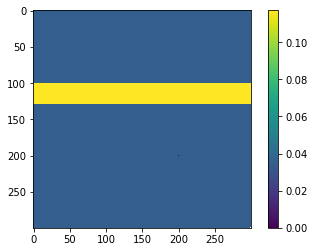

In [164]:
plt.imshow(cost_field)
plt.colorbar()

In [143]:
wdt = _wdt_python(cost_field)


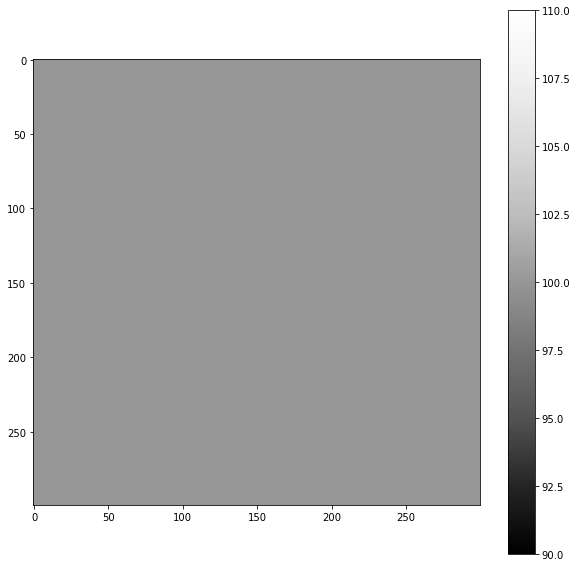

In [144]:
plt.figure(figsize=(10,10))
plt.imshow(wdt*100, cmap='Greys_r')
plt.colorbar()